In [2]:
import os, sys
import dotenv
dotenv.load_dotenv('../.env')

import numpy as np
import torch
import pandas as pd
from scipy.stats import kendalltau, pearsonr, spearmanr
import pandas as pd
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt

import wandb
from collections import defaultdict
import json
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy
import warnings

sys.path.append('../')
from common import OnnxModel, BOLT_DIR
from metrics.metrics import calculate_open_loop_metrics, calculate_closed_loop_metrics
from dataloading.nvidia import NvidiaElvaDataset, NvidiaDataset

WANDB_ENTITY = os.getenv('WANDB_ENTITY')
WANDB_PROJECT = os.getenv('WANDB_PROJECT')

In [3]:
def are_locations_close(loc_a, loc_b, threshold=50):
    return np.linalg.norm(loc_a - loc_b) < threshold

def get_closest_frame_by_loc(df, target_loc):
    locations = df[['position_x', 'position_y']].to_numpy().astype(np.float32)
    df['distance_to_target'] = np.linalg.norm(locations - target_loc)
    return df.loc[df['distance_to_target'].idxmin()]

def get_closest_row_idx_by_timestamp(df, dt):
    df['timestamp'] = pd.to_datetime(df['index'])
    return (abs(df['timestamp'] - dt)).idxmin()

def get_longest_intervention_periods(df):
    df['autonomous_next'] = df['autonomous'].shift(-1)
    starts_ends_df = df[(df['autonomous'] & (df['autonomous_next'] == False)) | ((df['autonomous'] == False) & df['autonomous_next'])]
    starts_ends = [row['row_id'] for i, row in starts_ends_df.iterrows()]
    starts = np.array(starts_ends)[::2]
    ends = np.array(starts_ends)[1::2]
    longest_idxs = np.argsort(ends - starts)
    return (starts[longest_idxs], ends[longest_idxs])

def split_back_forth_drive_into_two(dataset):

    frames_df = dataset.frames
    vehicle_cmd_df = dataset.vehicle_cmd_frames
    # find the longest intervention period
    found_direction_change = False
    for forward_end, forward_start in zip(*get_longest_intervention_periods(frames_df)):
        if are_locations_close(frames_df[frames_df['row_id'] == forward_end][['position_x', 'position_y']].to_numpy(), track_direction_change_location) or \
            are_locations_close(frames_df[frames_df['row_id'] == forward_start][['position_x', 'position_y']].to_numpy(), track_direction_change_location):
            found_direction_change = True
            break

    if not found_direction_change:
        print('Couldn\'t find the longest intervention in the track direction change location')
        return None

    # split the drive into two
    df1 = frames_df[frames_df['row_id'] <= forward_end]
    df2 = frames_df[frames_df['row_id'] > forward_start]

    forward_end_ts = pd.to_datetime(df1.iloc[-1]['index'])
    backward_start_ts = pd.to_datetime(df2.iloc[0]['index'])

    forward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, forward_end_ts)
    backward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, backward_start_ts)

    df1_vehicle_cmd = vehicle_cmd_df.iloc[:forward_end_idx]
    df2_vehicle_cmd = vehicle_cmd_df.iloc[backward_end_idx:]

    # save the pandas dataframes back into NvidiaDataset objects
    dataset_forward = deepcopy(dataset)
    dataset_backward = deepcopy(dataset)
    dataset_forward.frames = df1
    dataset_forward.vehicle_cmd_frames = df1_vehicle_cmd
    dataset_backward.frames = df2
    dataset_backward.vehicle_cmd_frames = df2_vehicle_cmd

    return dataset_forward, dataset_backward

In [4]:
track_direction_change_location = np.array([-9683.68050786, -1542.68155186])
root_path = Path(BOLT_DIR) / 'end-to-end/drives-ebm-paper'
expert_ds = NvidiaDataset([root_path / '2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk'])
expert_back_ds = NvidiaDataset([root_path / '2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk'])

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk: length=13858, filtered=2
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk: length=14249, filtered=1


In [35]:
import torchvision.transforms.functional as F
from PIL import Image

camera_crop_xmin = 300
camera_crop_xmax = 1620
camera_crop_ymin = 520
camera_crop_ymax = 864

resize_scale = 0.2

height = camera_crop_ymax - camera_crop_ymin
width = camera_crop_xmax - camera_crop_xmin
scaled_width = int(resize_scale * width)
scaled_height = int(resize_scale * height)

def crop(img):
    return img[camera_crop_ymin:camera_crop_ymax, camera_crop_xmin:camera_crop_xmax, :]

def resize_cv2(cv_img):
    return cv2.resize(cv_img, dsize=(scaled_width, scaled_height), interpolation=cv2.INTER_LINEAR)

def resize_pil(cv_img):
    pil_img = Image.fromarray(cv_img)
    return pil_img.resize((scaled_width, scaled_height))

class NvidiaCropWide(object):
    def __init__(self, antialias=False):
        self.antialias = antialias

    def __call__(self, data):
        xmin = 300
        xmax = 1620
        ymin = 520
        ymax = 864
        scale = 0.2

        height = ymax - ymin
        width = xmax - xmin
        cropped = data['image'][:, ymin:ymax, xmin:xmax]
        resized = F.resize(cropped, (int(scale * height), int(scale * width)), antialias=self.antialias)

        data["image"] = resized
        return data

In [36]:
img = cv2.imread(expert_ds.frames.iloc[0].image_path)
print('raw img:', img.shape)
# print('cropped img:', crop(img).shape)
resized_cv2 = resize_cv2(crop(img))
print('CV2 resized img:', resized_cv2.shape)

img_tensor = torch.tensor(img, dtype=torch.uint8).permute(2, 0, 1)
# print('img_tensor:', img_tensor.shape)
resized_torch = NvidiaCropWide()({'image': img_tensor})['image']
print('Torch resized img:', resized_torch.shape)

resized_torch_antialias = NvidiaCropWide(antialias=True)({'image': img_tensor})['image']
print('Torch resized img antialias:', resized_torch_antialias.shape)

resized_pil = resize_pil(crop(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
print('PIL resized img:', np.array(resized_pil).shape)

raw img: (1208, 1920, 3)
CV2 resized img: (68, 264, 3)
Torch resized img: torch.Size([3, 68, 264])
Torch resized img antialias: torch.Size([3, 68, 264])
PIL resized img: (68, 264, 3)


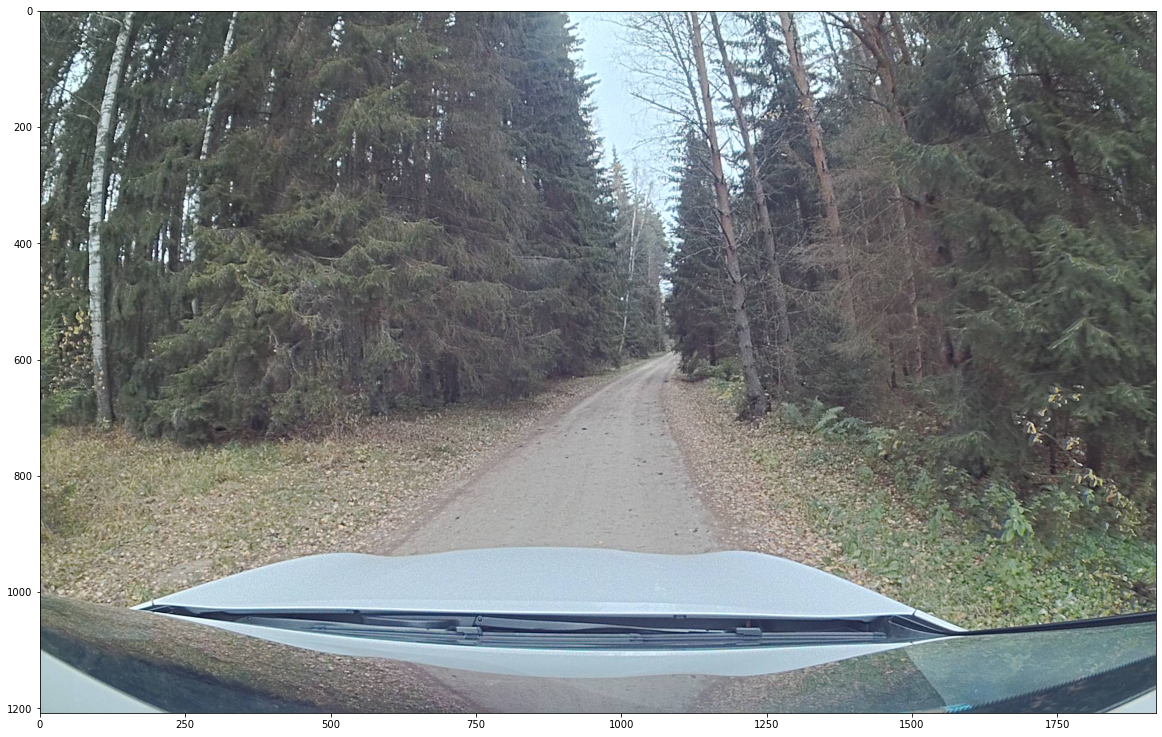

In [37]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# as opencv loads in BGR format by default, we want to show it in RGB.
plt.show()


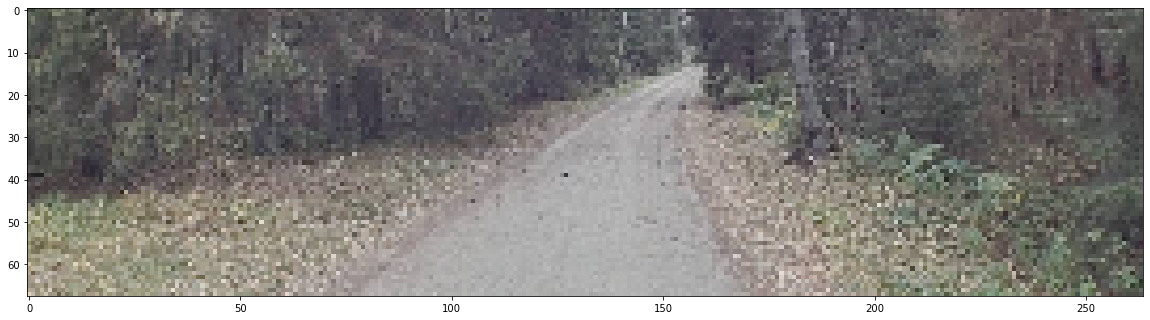

In [38]:
# cv2 version
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(resized_cv2, cv2.COLOR_BGR2RGB))
plt.show()


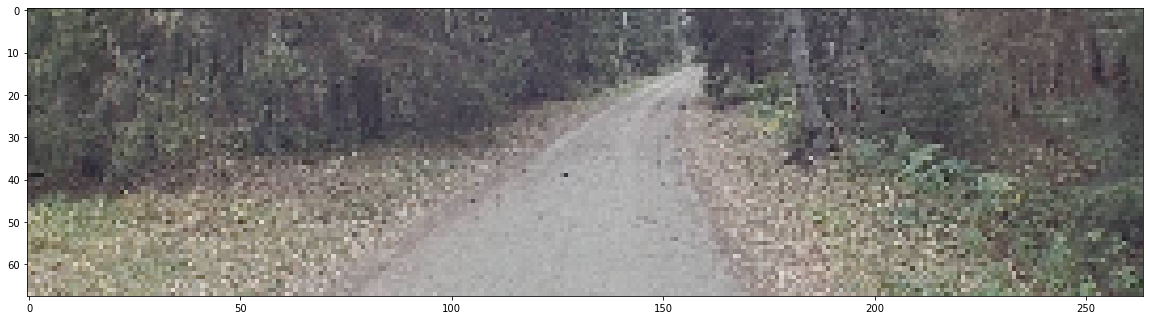

In [39]:
# torch version

plt.figure(figsize=(20,20))
resized_torch_np = resized_torch.permute(1, 2, 0).numpy()
plt.imshow(cv2.cvtColor(resized_torch_np, cv2.COLOR_BGR2RGB))
plt.show()


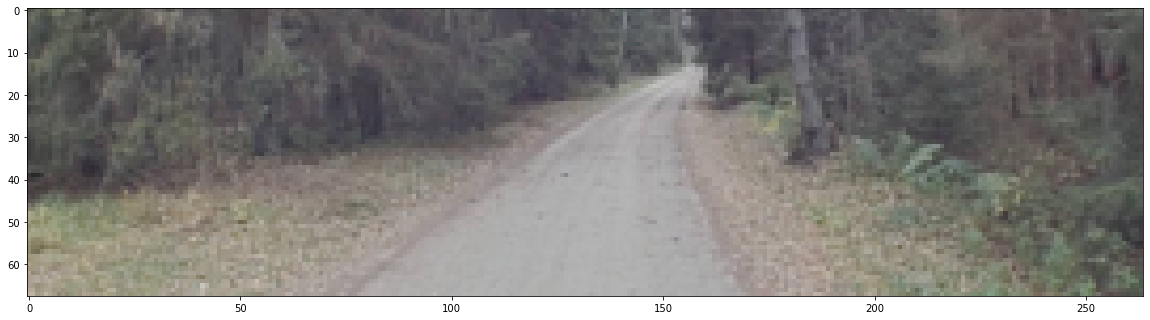

In [40]:
# torch antialias version

plt.figure(figsize=(20,20))
resized_torch_antialias_np = resized_torch_antialias.permute(1, 2, 0).numpy()
plt.imshow(cv2.cvtColor(resized_torch_antialias_np, cv2.COLOR_BGR2RGB))
plt.show()


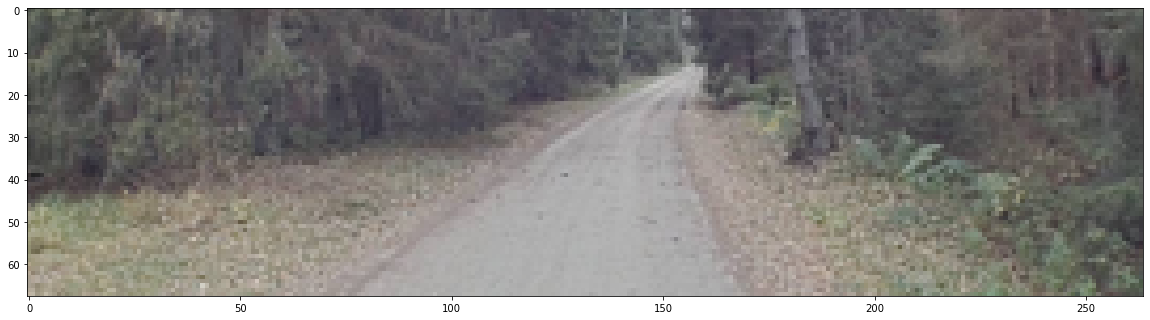

In [41]:
# pil

plt.figure(figsize=(20,20))
plt.imshow(np.array(resized_pil))
plt.show()
